In [49]:
# Usual imports
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from surprise import dump

%matplotlib inline

### Parsing data

In [2]:
# Source: https://nijianmo.github.io/amazon/index.html#code
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [3]:
Office_Reviews = getDF('Final_Project_Data/Office_Products_5.json.gz')

### EDA

In [4]:
Office_Reviews.shape

(800357, 12)

In [5]:
Office_Reviews.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"11 7, 2017",A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",1510012800,NaN,NaN
1,4.0,True,"03 7, 2017",A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,Bought this used and it came in great conditio...,Good,1488844800,NaN,NaN
2,5.0,True,"06 25, 2016",APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,1466812800,NaN,NaN
3,5.0,True,"02 21, 2016",A2DHERRZIPFU7X,0140503528,{'Format:': ' Paperback'},Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,1456012800,NaN,NaN
4,5.0,False,"08 2, 2015",A2XCLJRGFANRC,0140503528,{'Format:': ' Hardcover'},E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,1438473600,NaN,NaN


In [6]:
Office_Reviews.groupby('reviewerID').count().sort_values(by='overall', ascending=False)

,overall,verified,reviewTime,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
reviewerID,,,,,,,,,,,
A3TTVIQ9RRHNIB,323,323,323,323,160,323,323,323,323,2,0
A3OXHLG6DIBRW8,282,282,282,282,157,282,282,282,282,79,0
A3N77PJ4KP3CJP,251,251,251,251,145,251,251,251,251,0,0
AVU1ILDDYW301,218,218,218,218,136,218,218,218,218,20,0
AC5HC2TJVWOFT,191,191,191,191,173,191,191,191,191,1,0
...,...,...,...,...,...,...,...,...,...,...,...
A14B96TJGWOWJS,4,4,4,4,2,4,4,4,4,1,0
A3T0NHH5K0DMKQ,4,4,4,4,1,4,4,4,4,0,0
A1GWP3TK35V54N,4,4,4,4,2,4,4,4,4,0,0


In [7]:
Office_Reviews.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
image              object
dtype: object

### Cleaning Operations : 

In [8]:
# Dropping unwanted columns
Office_Reviews.drop(columns=['style', 'image'], inplace=True)

In [9]:
# Dropping complete duplicates
Office_Reviews.drop_duplicates(keep='first', inplace=True)

In [10]:
Office_Reviews.shape

(750515, 10)

In [11]:
# Dropping near-identical products whose reviews Amazon merges. For example, same product of different color.
col_to_check = list(Office_Reviews.columns)
col_to_check.remove('asin')

Office_Reviews = Office_Reviews[~Office_Reviews.duplicated(subset=col_to_check)]

In [12]:
Office_Reviews.shape

(666078, 10)

#### Dropping users who have less than 5 reviews

In [13]:
Office_Reviews = Office_Reviews.groupby('reviewerID').filter(lambda x: len(x) > 5)

#### Dropping products reviewed less than 15 times

In [14]:
Office_Reviews = Office_Reviews.groupby('asin').filter(lambda x: len(x) > 15)

In [15]:
Office_Reviews.shape

(311197, 10)

In [16]:
Office_Reviews.reviewerID.nunique()

47427

In [17]:
Office_Reviews.asin.nunique()

6591

## Baseline Model for comparison

In [20]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(Office_Reviews[['reviewerID', 'asin', 'overall']], reader)

In [26]:
# Creating Train and Test Sets
trainset, testset = train_test_split(data, test_size=0.2)

In [27]:
# Baseline Predictor
from surprise import NormalPredictor

# Make random recommendations
Random = NormalPredictor()

## Matrix Factorization - SVD

In [30]:
from surprise import SVD
from surprise.model_selection import GridSearchCV # For tuning

param_grid = {'n_epochs': [20, 30], 'lr_all': [0.005, 0.010],
              'n_factors': [50, 100]}
svd_best = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

svd_best.fit(data)

In [31]:
best_params = svd_best.best_params['rmse']
svd_tuned = SVD(n_epochs = best_params['n_epochs'], lr_all = best_params['lr_all'], n_factors = best_params['n_factors'])

## Neighbourhood based Collaborative Filtering

In [33]:
from surprise import KNNBasic

item_based_knn = KNNBasic(sim_options = {'name': 'cosine', 'user_based': False})

## Model Evaluation

### Rating Prediction Accuracy

In [34]:
# Using 3-fold cross validation
from surprise import accuracy
from surprise.model_selection import KFold

kf = KFold(n_splits=5)

rand_rmse_scores = []
svd_rmse_scores = []
item_rmse_scores = []

rand_mae_scores = []
svd_mae_scores = []
item_mae_scores = []

for trainset, testset in kf.split(data):

    # train and test algorithms.
    # Baseline
    Random.fit(trainset)
    predictions_rand = Random.test(testset)
    
    # SVD
    svd_tuned.fit(trainset)
    predictions_svd = svd_tuned.test(testset)
    
    # Item-based
    item_based_knn.fit(trainset)
    predictions_item = item_based_knn.test(testset)
    
    # Compute Root Mean Squared Error
    rand_rmse_scores.append(accuracy.rmse(predictions_rand, verbose=True))
    svd_rmse_scores.append(accuracy.rmse(predictions_svd, verbose=True))
    item_rmse_scores.append(accuracy.rmse(predictions_item, verbose=True))
    
    # Compute Mean Absolute Error
    rand_mae_scores.append(accuracy.mae(predictions_rand, verbose=True))
    svd_mae_scores.append(accuracy.mae(predictions_svd, verbose=True))
    item_mae_scores.append(accuracy.mae(predictions_item, verbose=True))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2434
RMSE: 0.9231
RMSE: 1.0499
MAE:  0.8795
MAE:  0.6356
MAE:  0.6553
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2507
RMSE: 0.9217
RMSE: 1.0444
MAE:  0.8877
MAE:  0.6328
MAE:  0.6531
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2524
RMSE: 0.9265
RMSE: 1.0472
MAE:  0.8891
MAE:  0.6361
MAE:  0.6563
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2486
RMSE: 0.9195
RMSE: 1.0452
MAE:  0.8877
MAE:  0.6339
MAE:  0.6556
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2543
RMSE: 0.9260
RMSE: 1.0552
MAE:  0.8891
MAE:  0.6355
MAE:  0.6571


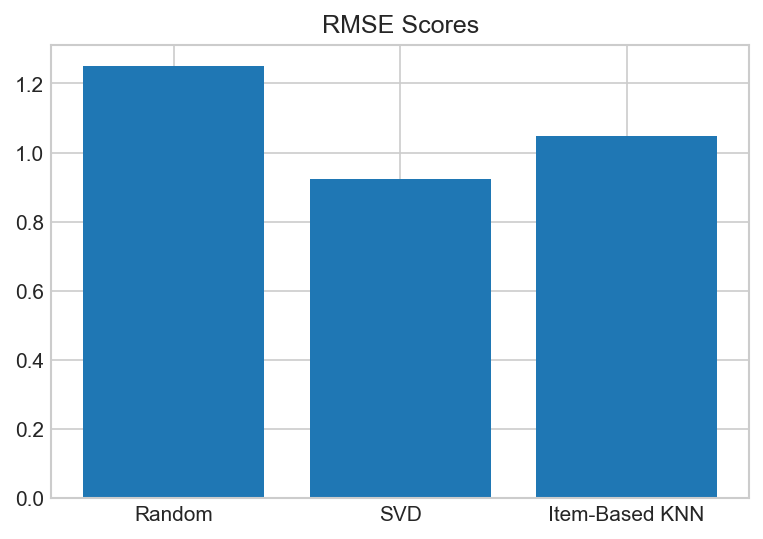

In [91]:
plt.figure(dpi=150)
rmse_means = np.mean(rand_rmse_scores), np.mean(svd_rmse_scores), np.mean(item_rmse_scores)
line_plot = plt.bar(['Random', 'SVD', 'Item-Based KNN'], rmse_means)
title = plt.title('RMSE Scores')

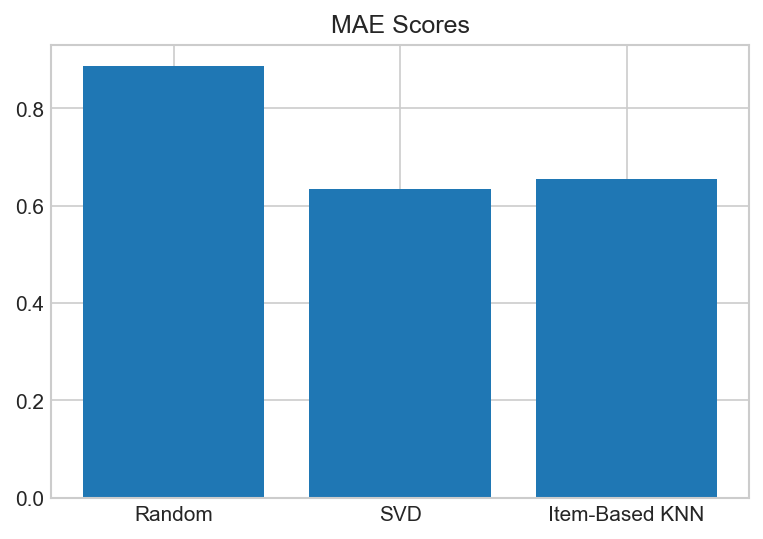

In [92]:
plt.figure(dpi=150)
mae_means = np.mean(rand_mae_scores), np.mean(svd_mae_scores), np.mean(item_mae_scores)
line_plot2 = plt.bar(['Random', 'SVD', 'Item-Based KNN'], mae_means)
title = plt.title('MAE Scores')

## Precision@K and Recall@K

In [68]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=4.0):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [83]:
kf = KFold(n_splits=5)

rand_prec_scores = []
svd_prec_scores = []
item_prec_scores = []

rand_recall_scores = []
svd_recall_scores = []
item_recall_scores = []

for trainset, testset in kf.split(data):

    # train and test algorithms.
    # Baseline
    Random.fit(trainset)
    predictions_rand = Random.test(testset)
    precisions, recalls = precision_recall_at_k(predictions_rand, k=10, threshold=4)
    rand_prec_scores.append(sum(prec for prec in precisions.values()) / len(precisions))
    rand_recall_scores.append(sum(rec for rec in recalls.values()) / len(recalls))
    
    # SVD
    svd_tuned.fit(trainset)
    predictions_svd = svd_tuned.test(testset)
    precisions, recalls = precision_recall_at_k(predictions_svd, k=10, threshold=4)
    svd_prec_scores.append(sum(prec for prec in precisions.values()) / len(precisions))
    svd_recall_scores.append(sum(rec for rec in recalls.values()) / len(recalls))
    
    # Item-based
    item_based_knn.fit(trainset)
    predictions_item = item_based_knn.test(testset)
    precisions, recalls = precision_recall_at_k(predictions_item, k=10, threshold=4)
    item_prec_scores.append(sum(prec for prec in precisions.values()) / len(precisions))
    item_recall_scores.append(sum(rec for rec in recalls.values()) / len(recalls))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


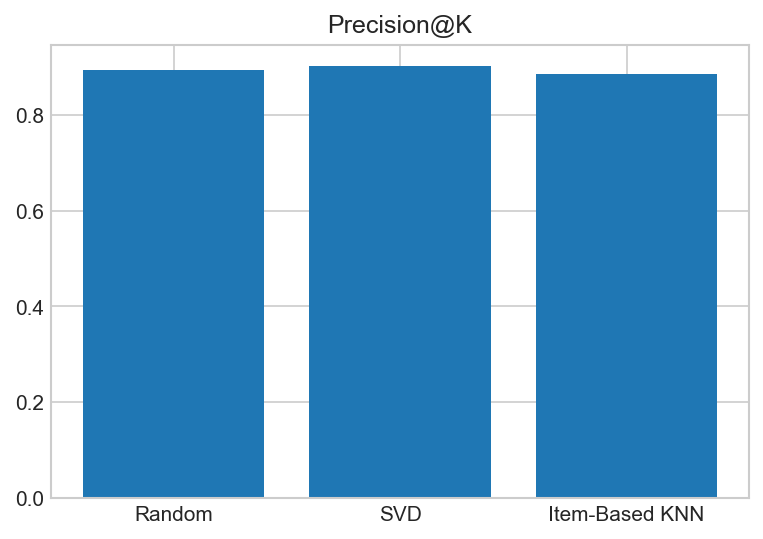

In [93]:
plt.figure(dpi=150)
prec_means = np.mean(rand_prec_scores), np.mean(svd_prec_scores), np.mean(item_prec_scores)
line_plot = plt.bar(['Random', 'SVD', 'Item-Based KNN'], prec_means)
title = plt.title('Precision@K')

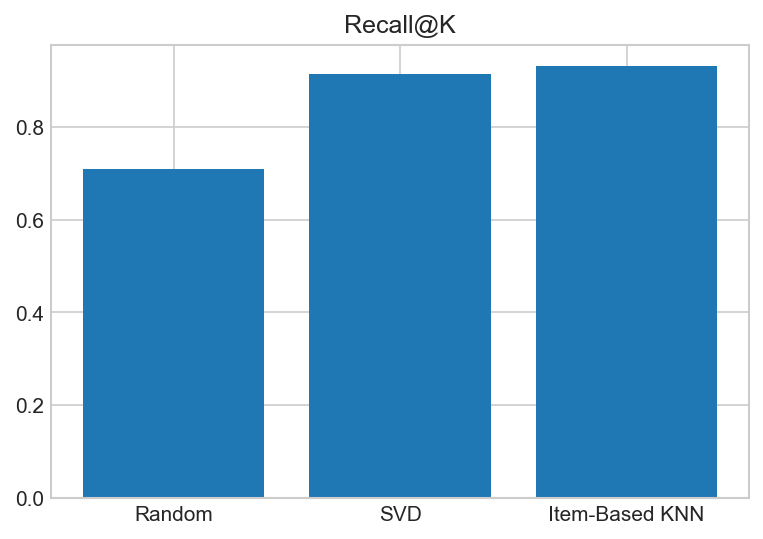

In [94]:
plt.figure(dpi=150)
recall_means = np.mean(rand_recall_scores), np.mean(svd_recall_scores), np.mean(item_recall_scores)
line_plot = plt.bar(['Random', 'SVD', 'Item-Based KNN'], recall_means)
title = plt.title('Recall@K')

### Top-N recommendation Rank based metrics

In [23]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [44]:
def AverageReciprocalHitRank(topNPredicted, leftOutPredictions):
    summation = 0
    total = 0
    # For each left-out rating
    for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
        # Is it in the predicted top N for this user?
        hitRank = 0
        rank = 0
        for movieID, predictedRating in topNPredicted[userID]:
            rank = rank + 1
            if (leftOutMovieID == movieID):
                hitRank = rank
                break
        if (hitRank > 0) :
            summation += 1.0 / hitRank

        total += 1

    return summation / total

Building model SVD

In [27]:
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut

trainSet, testSet = train_test_split(data, test_size=0.2, random_state=1)

svd = SVD(random_state=1)
svd.fit(trainSet)

In [28]:
predictions = svd.test(testSet)

Evaluation: Rating Prediction Accuracy

In [42]:
print("RMSE - ", RMSE(predictions))
print("MAE - ", MAE(predictions))

RMSE -  0.8355583999267348
MAE -  0.5805204749501834


Evaluating TopN recommendations

In [25]:
from surprise.model_selection import LeaveOneOut

LOOCV = LeaveOneOut(n_splits=1, random_state=1)

for trainSet, testSet in LOOCV.split(data):
    svd.fit(trainSet)
    dump.dump('testSet', testSet)

    # Predicts ratings for left-out ratings only
    print("Predict ratings for left-out set...")
    leftOutPredictions = svd.test(testSet)

    # Build predictions for all ratings not in the training set
    print("Predict all missing ratings...")
    bigTestSet = trainSet.build_anti_testset()
    dump.dump('bigTestSet', bigTestSet)
    allPredictions = svd.test(bigTestSet)

    # Compute top 10 recs for each user
    print("Compute top 10 recs per user...")
    topNPredicted = get_top_n(allPredictions, n=10)

    # Compute ARHR
    #print("\nARHR (Average Reciprocal Hit Rank): ", AverageReciprocalHitRank(topNPredicted, leftOutPredictions))

Predict ratings for left-out set...
Predict all missing ratings...
Compute top 10 recs per user...


In [32]:
topNPredicted = get_top_n(allPredictions, n=50)

In [27]:
def HitRate(topNPredicted, leftOutPredictions):
    hits = 0
    total = 0

    # For each left-out rating
    for leftOut in leftOutPredictions:
        userID = leftOut[0]
        leftOutMovieID = leftOut[1]
        # Is it in the predicted top 10 for this user?
        hit = False
        for movieID, predictedRating in topNPredicted[userID]:
            if (leftOutMovieID == movieID):
                hit = True
                break
        if (hit) :
            hits += 1

        total += 1

    # Compute overall precision
    return hits/total

In [33]:
HitRate(topNPredicted, leftOutPredictions)

0.032016210739615

In [19]:
# Loading office product meta-data mainly for product titles
unique_asins = set(Office_Reviews.asin.unique())
with gzip.open("Final_Project_Data/meta_Office_Products.json.gz", 'rt', encoding='utf-8') as f:
    meta = {}
    for line in f:
        metadata = json.loads(line)
        if metadata['asin'] in unique_asins:
            meta[metadata['asin']] = metadata.get('title', '')

In [47]:
from surprise import KNNBasic

ItemKNN = KNNBasic(sim_options = {'name': 'cosine', 'user_based': False})

In [48]:
predictions_knn = ItemKNN.fit(trainset).test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [73]:
precisions, recalls = precision_recall_at_k(predictions_knn, k=10, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8832942795346608
0.930793369613423


In [41]:
from surprise import SVDpp

SVDPlusPlus = SVDpp()
#predictions_svdpp = SVDPlusPlus.fit(trainset).test(testset)

In [77]:
precisions, recalls = precision_recall_at_k(predictions_svdpp, k=10, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8971749888024229
0.9194213345288047


In [82]:
# Baseline Predictor
from surprise import NormalPredictor

# Just make random recommendations
Random = NormalPredictor()
predictions_baseline = Random.fit(trainset).test(testset)

In [83]:
precisions, recalls = precision_recall_at_k(predictions_baseline, k=10, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8899336169254691
0.708212060135085


In [94]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp37-none-any.whl size=7850 sha256=87a65c73eb53338db1ef82e011d007fa1490e9db3397555fc23ff6b6c8ee61da
  Stored in directory: /Users/pranayparmar/Library/Caches/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [96]:
import ml_metrics

In [111]:
ml_metrics.apk([1,2,0],[0,3,1])

0.5555555555555555

In [35]:
HitRate(topNPredicted, leftOutPredictions)

0.005876393110435664

In [45]:
ItemKNN.fit(trainSet)

# Predicts ratings for left-out ratings only
print("Predict ratings for left-out set...")
leftOutPredictions_item = ItemKNN.test(testSet)

allPredictions_item = ItemKNN.test(bigTestSet)

# Compute top 10 recs for each user
print("Compute top 10 recs per user...")
topNPredicted_item = get_top_n(allPredictions_item, n=50)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Predict ratings for left-out set...


KeyboardInterrupt: 

In [ ]:
HitRate(topNPredicted_item, leftOutPredictions_item)

In [30]:
pd.DataFrame(testSet)[2].value_counts()

5.0    7050
4.0    1687
3.0     596
1.0     283
2.0     254
Name: 2, dtype: int64